# Demand Forecasting with Linear Regression

This notebook implements a demand forecasting approach using linear regression with lagged features.
The model is evaluated against a naive lag-1 baseline on a future hold-out test set.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

## Dataset

The dataset contains retail time series data with daily observations.
Key variables include inventory level, units sold and price.
The data is sorted chronologically and split into training and test sets based on time.

In [110]:
df = pd.read_csv("../data/inventory.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 7.8+ MB


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S004,P0013,Furniture,East,191,56,65,61.81,0,Sunny,0,63.92,Autumn
2,2022-01-01,S004,P0012,Electronics,North,349,9,165,14.25,5,Rainy,1,18.56,Spring
3,2022-01-01,S004,P0011,Electronics,West,205,46,27,54.84,0,Sunny,1,57.76,Spring
4,2022-01-01,S004,P0010,Groceries,East,447,104,96,33.48,15,Cloudy,0,37.15,Summer


## Feature Engineering

Lag features and a 7-day moving average are created to capture short-term demand dynamics.
Only past information is used to avoid data leakage.

In [111]:
df["Lag1"] = df["Inventory Level"].shift(1)
df["Lag2"] = df["Inventory Level"].shift(2)
df["MA7"] = df["Inventory Level"].rolling(window=7).mean()

df = df.dropna()

features = ["Lag1", "Lag2", "MA7", "Units Sold", "Price"]

x = df[features]
y = df["Inventory Level"]

split_index = int(len(x) * 0.8)

x_train, x_test = x.iloc[:split_index], x.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

assert len(x_test) > 0, "Test set ist leer"

## Model and Baseline

A linear regression model is trained on the historical data.
As a baseline, a naive lag-1 forecast is used, which predicts the next value as the previous observation.

In [112]:
model = LinearRegression()
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


## Evaluation

Model performance is evaluated using MAE and RMSE on a future hold-out test set.
Results are compared against the lag-1 baseline to assess added predictive value.

In [113]:
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print("=== Linear Regression ===")
print(f"MAE :  {mae:.2f}")
print(f"RMSE:  {rmse:.2f}")

=== Linear Regression ===
MAE :  79.04
RMSE:  97.32


In [114]:
y_pred_baseline = x_test["Lag1"].values

mae_base = mean_absolute_error(y_test, y_pred_baseline)
rmse_base = root_mean_squared_error(y_test, y_pred_baseline)

print("\n=== Baseline (Lag1) ===")
print(f"MAE :  {mae_base:.2f}")
print(f"RMSE:  {rmse_base:.2f}")



=== Baseline (Lag1) ===
MAE :  150.71
RMSE:  183.97


In [119]:
improvement = (rmse_base - rmse) / rmse_base * 100
print(f"Improvement: {improvement:.1f}%")

if rmse < rmse_base:
    print("\n✔ Model beats baseline")
else:
    print("\n✘ Model does NOT beat baseline")

Improvement: 47.1%

✔ Model beats baseline


In [ ]:
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", key=abs, ascending=False)

print("\n=== Feature Influence ===")
print(coef_df)


=== Feature Influence ===
      Feature  Coefficient
2         MA7     0.994730
3  Units Sold     0.603258
0        Lag1    -0.146519
1        Lag2    -0.138747
4       Price     0.056604

✔ Model beats baseline


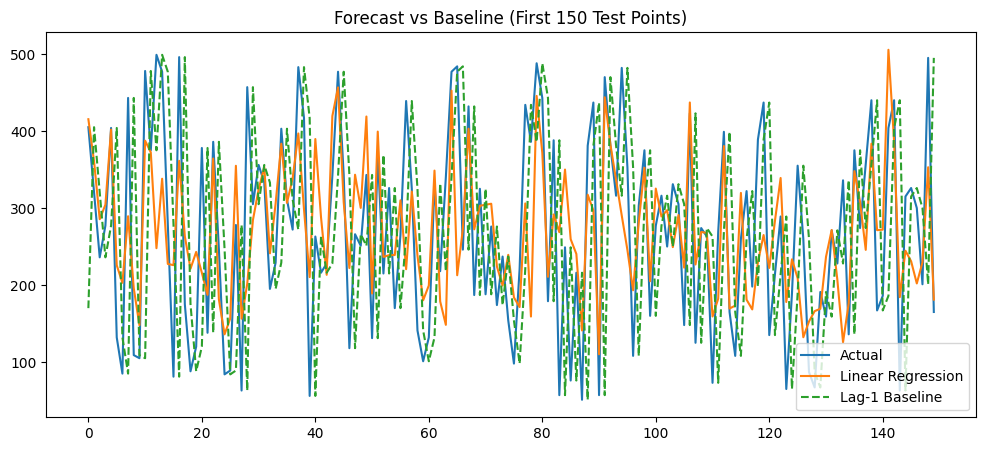

In [117]:
N = 150
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:N], label="Actual")
plt.plot(y_pred[:N], label="Linear Regression")
plt.plot(y_pred_baseline[:N], label="Lag-1 Baseline", linestyle="--")
plt.legend()
plt.title("Forecast vs Baseline (First 150 Test Points)")
plt.show()

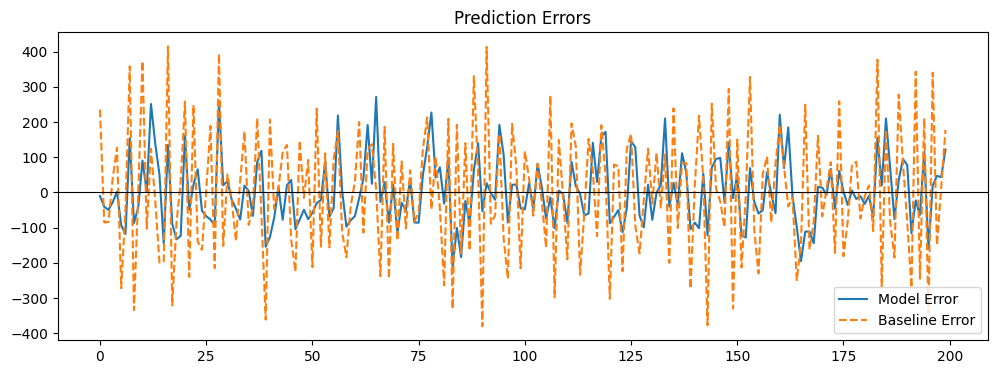

In [118]:
err_model = y_test.values - y_pred
err_base = y_test.values - y_pred_baseline
M = 200
plt.figure(figsize=(12,4))
plt.plot(err_model[:M], label="Model Error")
plt.plot(err_base[:M], label="Baseline Error", linestyle="--")
plt.axhline(0, color="black", linewidth=0.8)
plt.legend()
plt.title("Prediction Errors")
plt.show()

## Results and Limitations

The linear regression model significantly outperforms the naive baseline.
Demand dynamics appear largely driven by short-term historical patterns.

Limitations include the use of a single model and limited feature set.
Future work could explore non-linear models and additional external features.